In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def make_postage_stamp():
    x, y = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
    d = np.sqrt(x * x + y * y)
    sigma, mu = 0.5, 0.0
    a = 200.0 / (sigma * np.sqrt(2.0 * np.pi))
    g = a * np.exp(-((d - mu)**2 / (2.0 * sigma**2)))
    g = g.astype(np.int64)
    return g

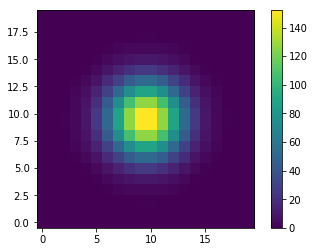

In [3]:
g = make_postage_stamp()
plt.figure()
plt.imshow(g, origin='lower')
plt.colorbar()

In [4]:
np.random.seed(1000)
ccd_shape = (480, 640)

In [5]:
def find_insertion_point(ccd_shape):
    percentage = 0.2
    x_range = percentage * ccd_shape[1]
    y_range = percentage * ccd_shape[0]
    # Pick lower left corner for insertion
    x_halfwidth = ccd_shape[1] / 2
    y_halfwidth = ccd_shape[0] / 2
    xpoint = np.random.randint(x_halfwidth - x_range, x_halfwidth + x_range + 1)
    ypoint = np.random.randint(y_halfwidth - y_range, y_halfwidth + y_range + 1)
    return (xpoint, ypoint)

In [6]:
def get_frame(spot, ccd_shape, ipoint):
    frame = np.random.poisson(20.0, ccd_shape)
    frame[ipoint[1]:ipoint[1] + spot.shape[0], ipoint[0]:ipoint[0] + spot.shape[1]] += spot
    return frame

In [7]:
insertion_point = find_insertion_point(ccd_shape)
print(insertion_point)
ccd = get_frame(g, ccd_shape, insertion_point)

(279, 215)


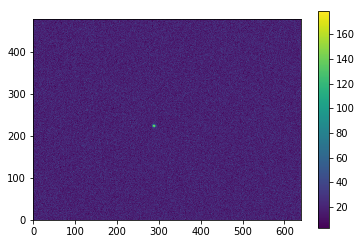

In [8]:
plt.imshow(ccd, origin='lower')
plt.colorbar()

In [9]:
np.where(ccd==np.max(ccd))

(array([225]), array([288]))

In [10]:
ccd.shape

(480, 640)

In [11]:
boxsize = 50
offset_x = (boxsize - g.shape[1]) // 2
offset_y = (boxsize - g.shape[0]) // 2
x_start = insertion_point[0] - offset_x
y_start = insertion_point[1] - offset_y
print(insertion_point)
print(x_start, y_start)
temp_roi = ccd[y_start:y_start + boxsize, x_start:x_start + boxsize]
print(temp_roi.shape)

(279, 215)
264 200
(50, 50)


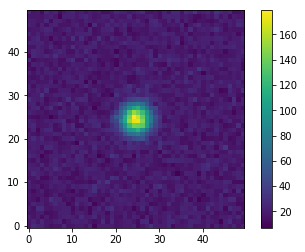

In [12]:
plt.imshow(temp_roi, origin='lower')
plt.colorbar()

In [13]:
np.where(temp_roi==np.max(temp_roi))

(array([25]), array([24]))

# Full Frame Processing

In [14]:
from scipy import ndimage

In [15]:
def make_labels(ccd):
    img_std = ndimage.standard_deviation(ccd)
    threshold = np.median(ccd) + 5.0 * img_std
    mask = ccd > threshold
    labels, numl = ndimage.label(mask)
    return labels, numl, mask, threshold

In [16]:
labels_image, num_labels, omask, image_threshold = make_labels(ccd)

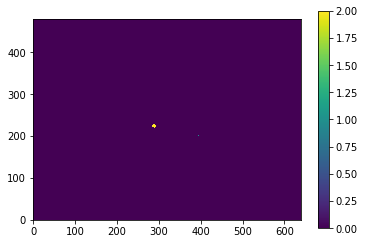

In [17]:
plt.imshow(labels_image, origin='lower')
plt.colorbar()

In [18]:
num_labels

2

In [19]:
def make_threshold_labels(labels_im, nb_labels, mask):
    sizes = ndimage.sum(mask, labels_im, range(nb_labels + 1))
    # The 10 is a number of pixels to be required in the feature
    mask_size = sizes < 10
    remove_pixel = mask_size[labels_im]
    labels_im[remove_pixel] = 0
    return labels_im

In [20]:
labels_image_thresh = make_threshold_labels(labels_image, num_labels, omask)

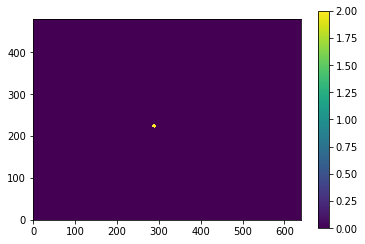

In [21]:
plt.imshow(labels_image_thresh, origin='lower')
plt.colorbar()

In [22]:
def get_spot(labels_im, mask, threshold, frame):
    labels = np.unique(labels_im)
    labels_im = np.searchsorted(labels, labels_im)
    objects = ndimage.find_objects(labels_im)
    size_obj = ndimage.sum(mask, labels_im, 1)
    # Original code has third parameter, but there doesn't seem to be one here
    y_slice, x_slice = objects[0]
    spot = frame[y_slice, x_slice] - threshold
    spot[spot < 0] = 0
    return spot, (x_slice, y_slice)

In [23]:
spot_image, image_slice = get_spot(labels_image_thresh, omask, image_threshold, ccd)

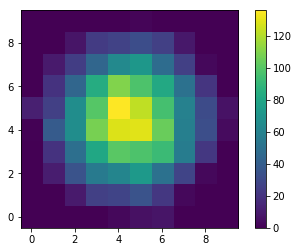

In [24]:
plt.imshow(spot_image, origin='lower')
plt.colorbar()

In [25]:
def create_information(spot_img, sslice):
    flux = spot_img.sum()
    count_max = spot_img.max()
    com_x, com_y = ndimage.center_of_mass(spot_img)
    cen_x = com_x + sslice[0].start
    cen_y = com_y + sslice[1].start
    return flux, count_max, cen_x, cen_y

In [26]:
image_flux, image_max_adc, center_x, center_y = create_information(spot_image, image_slice)

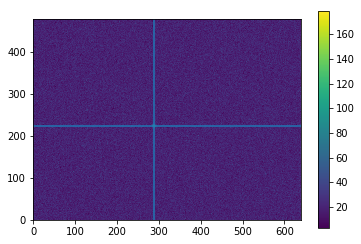

In [27]:
plt.imshow(ccd, origin='lower')
plt.axhline(center_y)
plt.axvline(center_x)
plt.colorbar()

In [28]:
print(center_x, center_y)

288.45394404821826 224.47687644439395


In [29]:
def get_pixel_center(cen_x, cen_y):
    pix_cen_x = int(cen_x)
    pix_cen_y = int(cen_y)
    return pix_cen_x, pix_cen_y

In [30]:
pixel_center_x, pixel_center_y = get_pixel_center(center_x, center_y)

In [31]:
def find_frame_spot_center(frame):
    labels_image, num_labels, omask, image_threshold = make_labels(frame)
    labels_image_thresh = make_threshold_labels(labels_image, num_labels, omask)
    spot_image, image_slice = get_spot(labels_image_thresh, omask, image_threshold, frame)
    image_flux, image_max_adc, center_x, center_y = create_information(spot_image, image_slice)
    return get_pixel_center(center_x, center_y)

In [32]:
image_center_x, image_center_y = find_frame_spot_center(ccd)
print(image_center_x, image_center_y)

288 224


# ROI Frame Processing

In [33]:
# Create ROI frame
boxsize = 50
threshold_factor = 0.3
num_roi_frames = 100

In [34]:
offset_x = int(image_center_x - boxsize / 2)
offset_y = int(image_center_y - boxsize / 2)

In [35]:
def make_roi(frame, offset, roi_size):
    return frame[offset_y:offset_y + boxsize, offset_x:offset_x + boxsize]

In [36]:
roi_orig = make_roi(ccd, (offset_x, offset_y), boxsize)

In [37]:
def create_roi_information(frame_orig, factor):
    frame = np.copy(frame_orig)
    frame = frame - factor * frame.max()
    frame[frame < 0] = 0
    max_adc = frame.max()
    flux = np.sum(frame)
    com_x, com_y = ndimage.center_of_mass(frame)
    size_obj = np.count_nonzero(frame)
    max_std = np.std(np.ma.masked_array(frame_orig, mask=frame))
    return max_adc, flux, com_x, com_y, size_obj, max_std

In [38]:
roi_max_adc, roi_flux,\
roi_com_x, roi_com_y,\
roi_size_obj, roi_max_std = create_roi_information(roi_orig, threshold_factor)

In [39]:
print(create_roi_information(temp_roi, threshold_factor))

(125.30000000000001, 2592.2000000000003, 24.46080549340329, 24.492516009567165, 54, 5.1785375980622534)


In [40]:
cent_x_array = [roi_com_x + offset_x]
cent_y_array = [roi_com_y + offset_y]
flux_array = [roi_flux]
max_adc_array = [roi_max_adc]
obj_size_array = [roi_size_obj]
max_std_array = []
if not np.isnan(roi_max_std):
    max_std_array.append(roi_max_std)

In [41]:
for i in range(num_roi_frames - 1):
    ccd = get_frame(g, ccd_shape, insertion_point)
    image_center_x, image_center_y = find_frame_spot_center(ccd)
    offset_x = int(image_center_x - boxsize / 2)
    offset_y = int(image_center_y - boxsize / 2)
    roi_orig = make_roi(ccd, (offset_x, offset_y), boxsize)
    roi_max_adc, roi_flux,\
    roi_com_x, roi_com_y,\
    roi_size_obj, roi_max_std = create_roi_information(roi_orig, threshold_factor)
    cent_x_array.append(roi_com_x + offset_x)
    cent_y_array.append(roi_com_y + offset_y)
    flux_array.append(roi_flux)
    max_adc_array.append(roi_max_adc)
    obj_size_array.append(roi_size_obj)
    if not np.isnan(roi_max_std):
        max_std_array.append(roi_max_std)

# FFT of ROI Centroids

In [42]:
x_mean = np.mean(cent_x_array)
y_mean = np.mean(cent_y_array)
#print(x_mean, y_mean)

In [43]:
from scipy.fftpack import fftfreq, rfft

In [44]:
#print(cent_x_array - x_mean)
x_fft = rfft(cent_x_array - x_mean)
y_fft = rfft(cent_y_array - y_mean)

In [45]:
L = len(cent_x_array)

In [46]:
freqs = fftfreq(L, 30 / L)
#print(freqs)
pf = freqs[1:L//2]

In [47]:
fx = 20.0 * np.log10(x_fft[1:L//2])
fy = 20.0 * np.log10(y_fft[1:L//2])
#fx = x_fft[1:L//2]
#fy = y_fft[1:L//2]

/Users/mareuter/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/mareuter/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


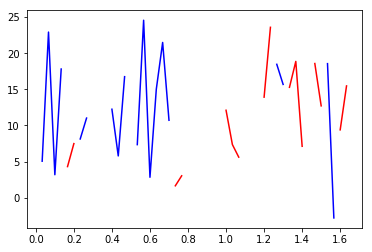

In [48]:
plt.plot(pf, fx, '-b')
plt.plot(pf, fy, '-r')